In [2]:
# Step 1 - Load and Merge Datasets

import pandas as pd

# Load datasets
bio_df = pd.read_excel('Bioimpedance_Synthetic.xlsx')
health_df = pd.read_excel('Health_Exam_Synthetic.xlsx')
hrv_df = pd.read_excel('HRV_Synthetic.xlsx')

# Check shape and columns of each dataframe
print("Bioimpedance:", bio_df.shape)
print("Health Exam:", health_df.shape)
print("HRV:", hrv_df.shape)

print("\nBioimpedance columns:", bio_df.columns.tolist())
print("\nHealth Exam columns:", health_df.columns.tolist())
print("\nHRV columns:", hrv_df.columns.tolist())

# Merge datasets
# Assuming there is a common column (like ID or Subject_ID) to merge on
# Let's assume column name is 'ID' (you can tell me the correct one after we print columns!)

# Example merge code:
# merged_df = health_df.merge(bio_df, on='ID').merge(hrv_df, on='ID')

# For now, do NOT run the merge — first let's inspect columns and decide the merge key!

# Save this code as step1_load_merge.py or run it in notebook


Bioimpedance: (200, 38)
Health Exam: (200, 33)
HRV: (200, 11)

Bioimpedance columns: ['USUBJID', 'TBW', 'ICW', 'ECW', 'PROT', 'MINERAL', 'SLM', 'FFM', 'SMM', 'PBF', 'SLRA–SLLL', 'SWRA–SWLL', 'ICWRA–ICWLL', 'ECWRA–ECWLL', 'ECWR', 'ECWRRA–ECWRLL', 'FATRA–FATLL', 'BMR', 'ABFR', 'VFA', 'BCM', 'BRMC', 'BMC', 'BHYDR', 'FFMI', 'FMI', 'CHMC', 'ABDMC', 'RAMC', 'LAMC', 'RLMC', 'LLMC', 'CHSTFATTHICK', 'ABDMFATTHICK', 'RAFATTHICK', 'LAFATTHICK', 'RLFATTHICK', 'LLFATTHICK']

Health Exam columns: ['USUBJID', 'SITEID', 'BIRTHDTC', 'SEX', 'MSYN', 'HEIGHT', 'WEIGHT', 'BMI', 'SYSBP', 'DIABP', 'PULSE', 'SMOKECNF', 'ALCOHOLYN', 'MH_HL', 'MH_HTN', 'MH_DM', 'CM_HL', 'CM_HTN', 'CM_DM', 'cold', 'heat', 'chcat', 'PSSTOTAL', 'PSQITOTAL', 'CREAT', 'GFRE', 'HGB', 'GLUC', 'AST', 'ALT', 'GGT', 'WAISTCIR', 'HIPCIR']

HRV columns: ['USUBJID', 'DVDTC', 'VLF', 'LF', 'HF', 'TP', 'LFNM', 'HFNM', 'HR', 'HRVINDEX', 'SDNN']


In [3]:
# Merge datasets on USUBJID
merged_df = health_df.merge(bio_df, on='USUBJID').merge(hrv_df, on='USUBJID')

# Check shape and first few rows
print("Merged dataframe shape:", merged_df.shape)
merged_df.head()

# Example if Exam Date is fixed
ref_date = pd.to_datetime('2024-01-01')
merged_df['BIRTHDTC'] = pd.to_datetime(merged_df['BIRTHDTC'])
merged_df['AGE'] = (ref_date - merged_df['BIRTHDTC']).dt.days // 365




Merged dataframe shape: (200, 80)


In [4]:
# Step 2.1 - Compute AGE from BIRTHDTC

# Convert BIRTHDTC to datetime
merged_df['BIRTHDTC'] = pd.to_datetime(merged_df['BIRTHDTC'], errors='coerce')

# Define reference date (e.g. 2024-01-01)
ref_date = pd.to_datetime('2024-01-01')

# Compute AGE in years
merged_df['AGE'] = (ref_date - merged_df['BIRTHDTC']).dt.days // 365

# Check AGE distribution
print("AGE min:", merged_df['AGE'].min())
print("AGE max:", merged_df['AGE'].max())
merged_df[['USUBJID', 'AGE']].head()


AGE min: 48
AGE max: 83


,USUBJID,AGE
0,SUBJ_0000,73
1,SUBJ_0001,69
2,SUBJ_0002,78
3,SUBJ_0003,66
4,SUBJ_0004,48


In [5]:
# Step 2.2 - Create AGE_GROUP column

merged_df['AGE_GROUP'] = pd.cut(
    merged_df['AGE'],
    bins=[50, 60, 70, 80, 120],
    labels=['50-59', '60-69', '70-79', '80+']
)

# Check AGE_GROUP distribution
print(merged_df['AGE_GROUP'].value_counts())


AGE_GROUP
70-79    62
60-69    56
50-59    51
80+      18
Name: count, dtype: int64


In [ ]:
# Step 3 - Prepare Features (X) and Target (y) - Full Fixed Version

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Drop rows where AGE_GROUP is NaN (AGE < 50)
merged_df_clean = merged_df.dropna(subset=['AGE_GROUP'])

#Target (y)
y = merged_df_clean['AGE_GROUP']

#Drop columns we don't want in features
drop_cols = ['USUBJID', 'BIRTHDTC', 'AGE', 'AGE_GROUP']

# Select numerical features only
X = merged_df_clean.drop(columns=drop_cols)
X = X.select_dtypes(include='number')

# Print info
print("Cleaned feature matrix shape:", X.shape)
print("Cleaned target shape:", y.shape)
print("Selected features:", X.columns.tolist())

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Final check
print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)


Cleaned feature matrix shape: (187, 65)
Cleaned target shape: (187,)
Selected features: ['HEIGHT', 'WEIGHT', 'BMI', 'SYSBP', 'DIABP', 'PULSE', 'cold', 'heat', 'PSSTOTAL', 'PSQITOTAL', 'CREAT', 'GFRE', 'HGB', 'GLUC', 'AST', 'ALT', 'GGT', 'WAISTCIR', 'HIPCIR', 'TBW', 'ICW', 'ECW', 'PROT', 'MINERAL', 'SLM', 'FFM', 'SMM', 'PBF', 'SLRA–SLLL', 'SWRA–SWLL', 'ICWRA–ICWLL', 'ECWRA–ECWLL', 'ECWR', 'ECWRRA–ECWRLL', 'FATRA–FATLL', 'BMR', 'ABFR', 'VFA', 'BCM', 'BRMC', 'BMC', 'BHYDR', 'FFMI', 'FMI', 'CHMC', 'ABDMC', 'RAMC', 'LAMC', 'RLMC', 'LLMC', 'CHSTFATTHICK', 'ABDMFATTHICK', 'RAFATTHICK', 'LAFATTHICK', 'RLFATTHICK', 'LLFATTHICK', 'VLF', 'LF', 'HF', 'TP', 'LFNM', 'HFNM', 'HR', 'HRVINDEX', 'SDNN']
Train shape: (130, 65)
Test shape: (57, 65)


In [9]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/150.0 MB 8.4 MB/s eta 0:00:18
   ---------------------------------------- 1.6/150.0 MB 4.7 MB/s eta 0:00:32
    --------------------------------------- 2.6/150.0 MB 5.2 MB/s eta 0:00:29
   - -------------------------------------- 3.9/150.0 MB 4.8 MB/s eta 0:00:31
   - -------------------------------------- 4.7/150.0 MB 4.5 MB/s eta 0:00:33
   - -------------------------------------- 5.5/150.0 MB 4.8 MB/s eta 0:00:31
   - -------------------------------------- 6.8/150.0 MB 4.8 MB/s eta 0:00:31
   -- ------------------------------------- 7.9/150.0 MB 4.8 MB/s eta 0:00:30
   -- ------------------------------------- 8.9/150.0 MB 4.9 MB/s eta 0:00:29
   -- ------------------------------------- 10.2/150.0 MB 5.0 MB/s eta 0:00:29
   -- ------------------------------------- 11.0/150.0 MB 4.9 MB/s eta 0:00:29
   --- ------------------------------------ 12.1/150.0 MB 5.0 MB/s et


====== Logistic Regression ======
Accuracy: 0.3860
F1 Score (macro): 0.3492
Classification Report:
              precision    recall  f1-score   support

       50-59       0.40      0.38      0.39        16
       60-69       0.33      0.35      0.34        17
       70-79       0.53      0.47      0.50        19
         80+       0.14      0.20      0.17         5

    accuracy                           0.39        57
   macro avg       0.35      0.35      0.35        57
weighted avg       0.40      0.39      0.39        57



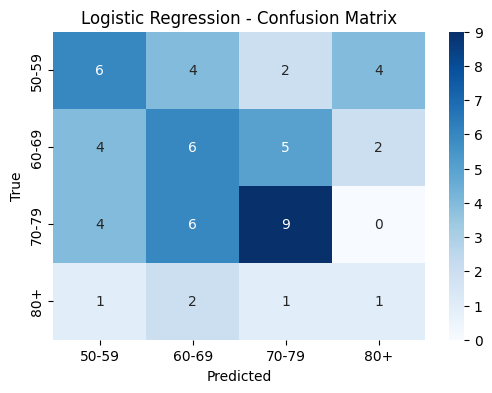


====== Random Forest ======
Accuracy: 0.3158
F1 Score (macro): 0.2224
Classification Report:
              precision    recall  f1-score   support

       50-59       0.27      0.19      0.22        16
       60-69       0.20      0.18      0.19        17
       70-79       0.39      0.63      0.48        19
         80+       0.00      0.00      0.00         5

    accuracy                           0.32        57
   macro avg       0.21      0.25      0.22        57
weighted avg       0.27      0.32      0.28        57



c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


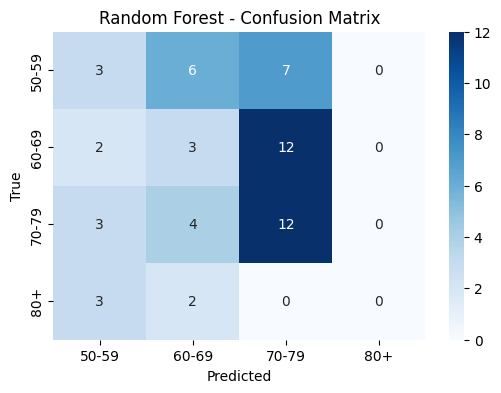


====== XGBoost ======


c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\xgboost\training.py:183: UserWarning: [04:10:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.4211
F1 Score (macro): 0.3366
Classification Report:
              precision    recall  f1-score   support

       50-59       0.46      0.38      0.41        16
       60-69       0.40      0.47      0.43        17
       70-79       0.48      0.53      0.50        19
         80+       0.00      0.00      0.00         5

    accuracy                           0.42        57
   macro avg       0.33      0.34      0.34        57
weighted avg       0.41      0.42      0.41        57



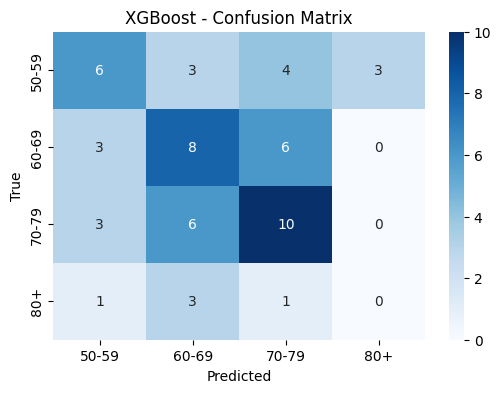

In [12]:
# Step 4 - Model Building (Notebook Cell - Clean Version)

# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Label encoding for XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n====== {name} ======")
    
    # Train
    if name == 'XGBoost':
        model.fit(X_train_scaled, y_train_enc)
    else:
        model.fit(X_train_scaled, y_train)
    
    # Predict
    if name == 'XGBoost':
        y_pred = model.predict(X_test_scaled)
        y_pred_labels = le.inverse_transform(y_pred)  # Convert back to original labels for report
    else:
        y_pred = model.predict(X_test_scaled)
        y_pred_labels = y_pred
    
    # Metrics
    acc = accuracy_score(y_test, y_pred_labels)
    f1 = f1_score(y_test, y_pred_labels, average='macro')
    
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_labels))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_labels, labels=le.classes_)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [13]:
!pip install shap


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
   ---------------------------------------- 0.0/544.2 kB ? eta -:--:--
   ---------------------------------------- 544.2/544.2 kB 6.0 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.8 MB 8.5 MB/s eta 0:00:01
   ------------------------------------- -- 2.6/2.8 MB 7.9 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 7.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   -- ------------------------------------- 1.6/30.3 MB 9.3 MB/s eta 0:00:04
   ---- ----------------------------------- 3.1/30.3 MB 7.4 MB/s eta 0:00:04
   ----- ---------------------------------- 4.2/30.3 MB 6.5 MB/s eta 0:00:05
   -----

c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


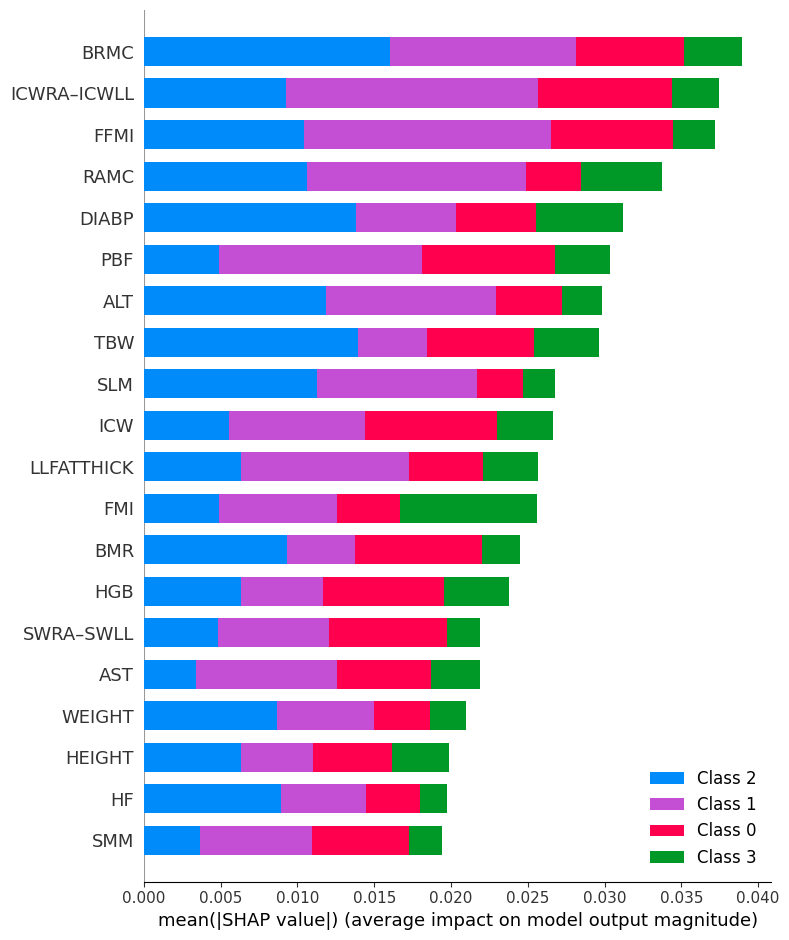

In [14]:
# Step 5 - SHAP Explainability

import shap

# Use the trained RandomForest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)

# Create SHAP explainer
explainer = shap.Explainer(model_rf, X_train_scaled)

# Compute SHAP values
shap_values = explainer(X_test_scaled)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


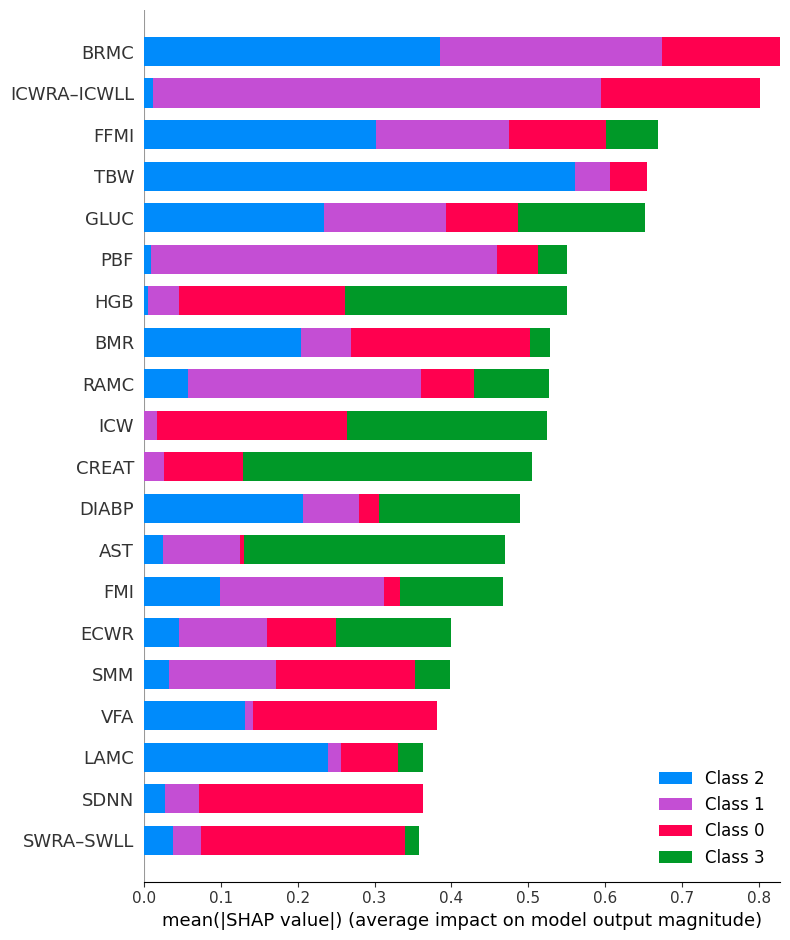

In [15]:
# Step 5b - SHAP for XGBoost

model_xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
model_xgb.fit(X_train_scaled, y_train_enc)

# Create SHAP explainer
explainer_xgb = shap.Explainer(model_xgb, X_train_scaled)

# Compute SHAP values
shap_values_xgb = explainer_xgb(X_test_scaled)

# Summary plot
shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns)


Top 5 features: ['ICWRA–ICWLL', 'FFMI', 'RAMC', 'LLFATTHICK', 'BRMC']


C:\Users\RAZER\AppData\Local\Temp\ipykernel_50332\1240867106.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = merged_df_clean.groupby('AGE_GROUP')[feature].median()  # or use .mean()


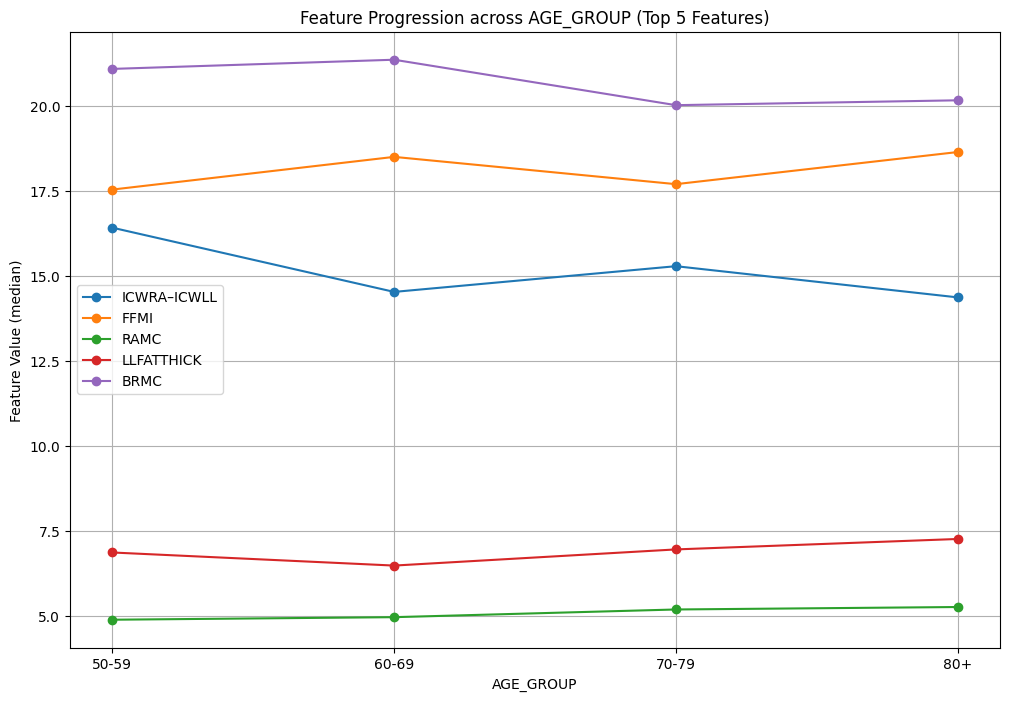

In [16]:
# Step 6 - Feature Progression Analysis

import matplotlib.pyplot as plt

# First compute RandomForest feature importance as example
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Select top N features to plot
top_n = 5
top_features = feature_importances.head(top_n).index.tolist()

print(f"Top {top_n} features:", top_features)

# Plot progression of each top feature
plt.figure(figsize=(12, 8))

for feature in top_features:
    group_stats = merged_df_clean.groupby('AGE_GROUP')[feature].median()  # or use .mean()
    plt.plot(group_stats.index, group_stats.values, marker='o', label=feature)

plt.title(f"Feature Progression across AGE_GROUP (Top {top_n} Features)")
plt.xlabel("AGE_GROUP")
plt.ylabel("Feature Value (median)")
plt.legend()
plt.grid(True)
plt.show()


In [17]:

!pip install umap-learn



   -------------------- ------------------- 1/2 [umap-learn]
   ---------------------------------------- 2/2 [umap-learn]



c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

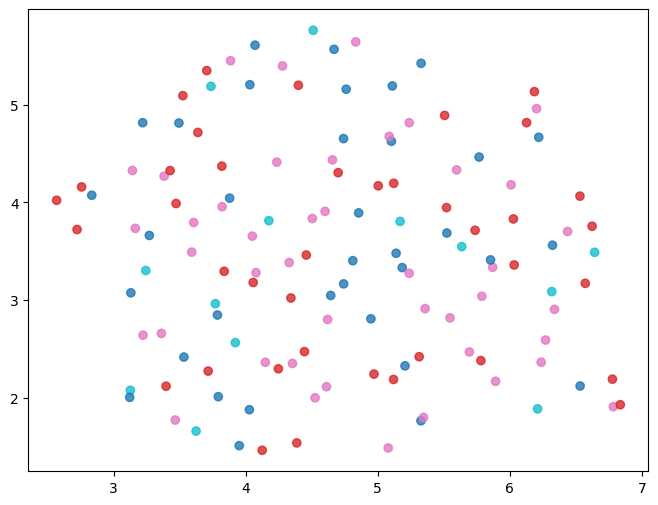

In [18]:
# Step 7 - UMAP Visualization


import umap
import matplotlib.pyplot as plt

# Fit UMAP on scaled features
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_train_scaled)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=le.transform(y_train), cmap='tab10', alpha=0.8)
plt.legend(handles=scatter.legend_elements()[0], labels=le.classes_, title="AGE_GROUP")
plt.title("UMAP Projection colored by AGE_GROUP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()


Total samples: 57
Samples flagged as accelerated aging (predicted older): 16
Percent accelerated aging: 28.07%


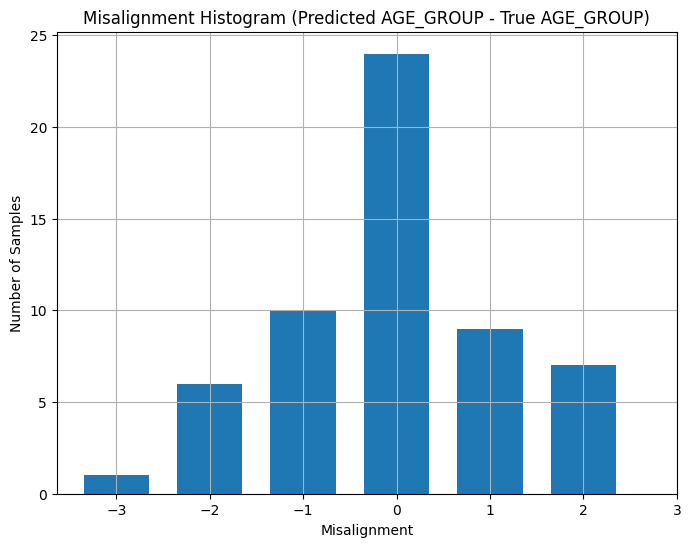

In [20]:
# Define AGE_GROUP order mapping
age_group_order = {'50-59': 0, '60-69': 1, '70-79': 2, '80+': 3}

# Map y_test and predictions to integers
y_test_ord = y_test.map(age_group_order).astype(int).values
y_pred_ord = pd.Series(y_pred_labels_xgb).map(age_group_order).astype(int).values

# Compute Misalignment
misalignment = y_pred_ord - y_test_ord

# Analyze results
import numpy as np
n_total = len(misalignment)
n_accelerated = np.sum(misalignment > 0)
percent_accelerated = 100 * n_accelerated / n_total

print(f"Total samples: {n_total}")
print(f"Samples flagged as accelerated aging (predicted older): {n_accelerated}")
print(f"Percent accelerated aging: {percent_accelerated:.2f}%")

# Plot misalignment histogram
plt.figure(figsize=(8,6))
plt.hist(misalignment, bins=np.arange(-3,4), align='left', rwidth=0.7)
plt.xticks(ticks=[-3, -2, -1, 0, 1, 2, 3])
plt.title("Misalignment Histogram (Predicted AGE_GROUP - True AGE_GROUP)")
plt.xlabel("Misalignment")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


Total samples: 57
Samples flagged as accelerated aging (predicted older): 16
Percent accelerated aging: 28.07%


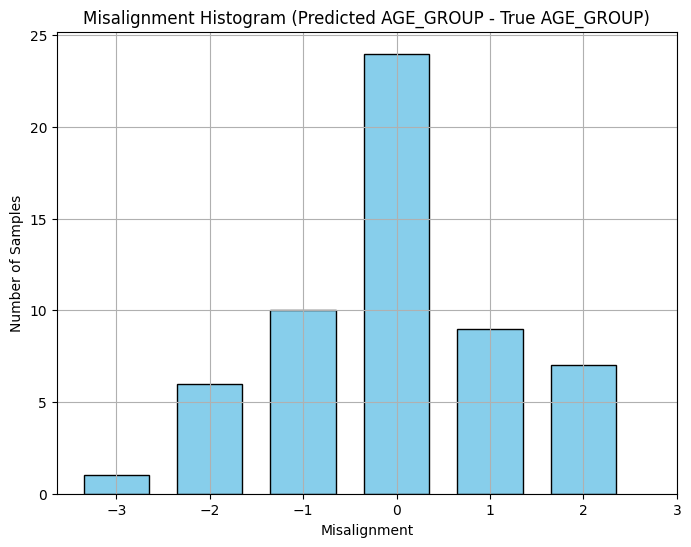

In [22]:
# Step 8 - Accelerated Aging Detection (Clean Version)

# Define AGE_GROUP order mapping
age_group_order = {'50-59': 0, '60-69': 1, '70-79': 2, '80+': 3}

# Map y_test and predictions to integers
y_test_ord = y_test.map(age_group_order).astype(int).values
y_pred_ord = pd.Series(y_pred_labels_xgb).map(age_group_order).astype(int).values

# Compute Misalignment
misalignment = y_pred_ord - y_test_ord

# Analyze results
import numpy as np
n_total = len(misalignment)
n_accelerated = np.sum(misalignment > 0)
percent_accelerated = 100 * n_accelerated / n_total

print(f"Total samples: {n_total}")
print(f"Samples flagged as accelerated aging (predicted older): {n_accelerated}")
print(f"Percent accelerated aging: {percent_accelerated:.2f}%")

# Plot misalignment histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(misalignment, bins=np.arange(-3,4), align='left', rwidth=0.7, color='skyblue', edgecolor='black')
plt.xticks(ticks=[-3, -2, -1, 0, 1, 2, 3])
plt.title("Misalignment Histogram (Predicted AGE_GROUP - True AGE_GROUP)")
plt.xlabel("Misalignment")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()



=== Subgroup model for AGE_GROUP: 50-59 ===


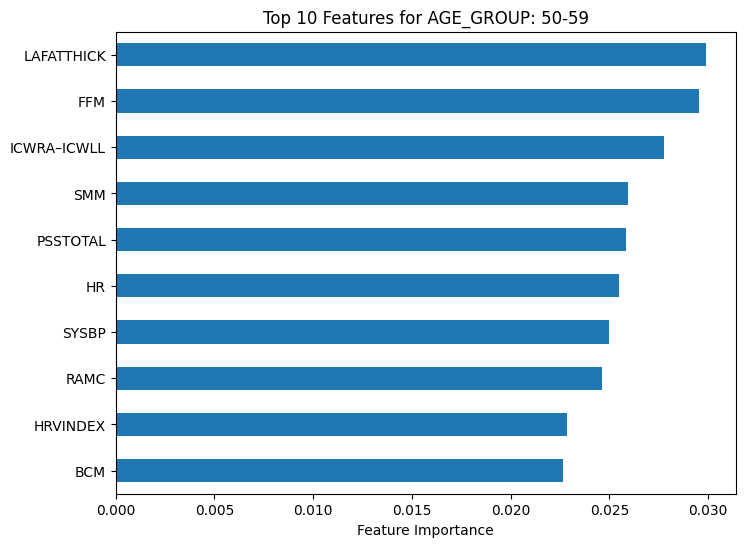


=== Subgroup model for AGE_GROUP: 60-69 ===


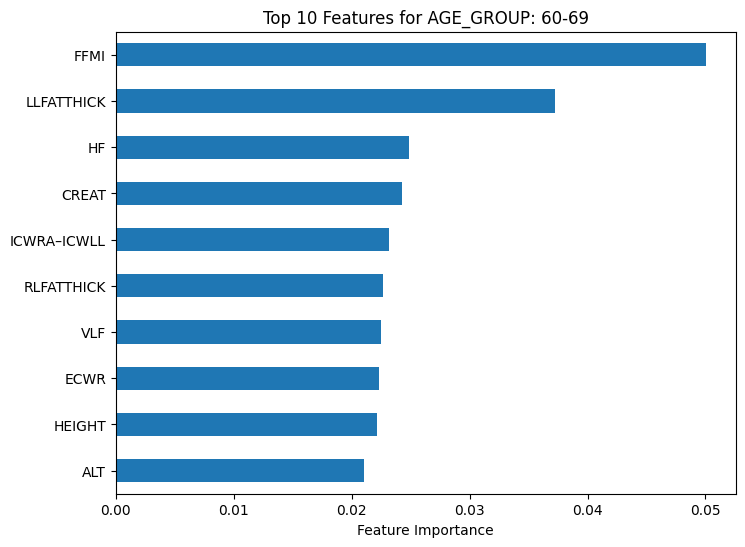


=== Subgroup model for AGE_GROUP: 70-79 ===


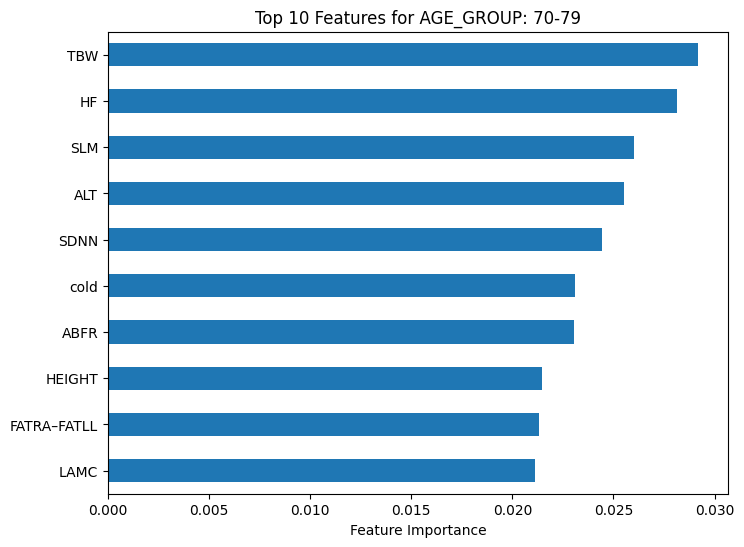


=== Subgroup model for AGE_GROUP: 80+ ===


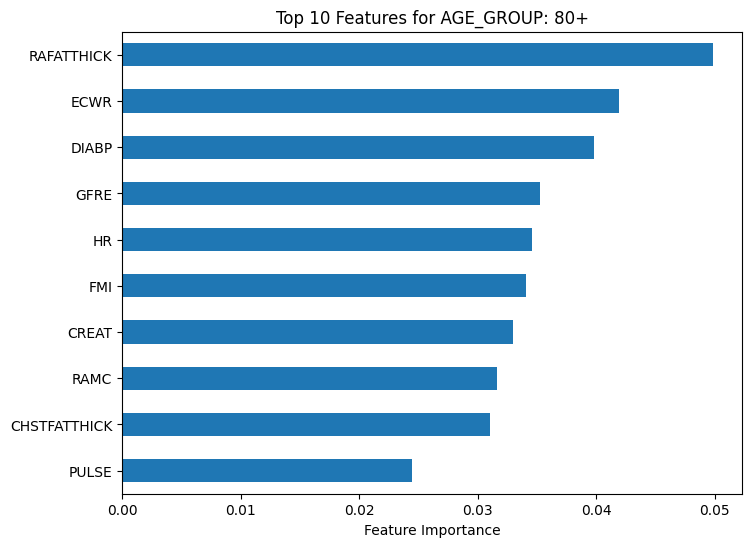

In [23]:
# Step 9 - Subgroup-Specific Modeling

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Define AGE_GROUPs
age_groups = ['50-59', '60-69', '70-79', '80+']

# For each AGE_GROUP:
for group in age_groups:
    print(f"\n=== Subgroup model for AGE_GROUP: {group} ===")
    
    # Binary target: 1 if in group, 0 otherwise
    y_binary = (y_train == group).astype(int)
    
    # Train RandomForest
    model_sub = RandomForestClassifier(n_estimators=100, random_state=42)
    model_sub.fit(X_train_scaled, y_binary)
    
    # Feature importances
    feature_importances_sub = pd.Series(model_sub.feature_importances_, index=X.columns)
    feature_importances_sub = feature_importances_sub.sort_values(ascending=False)
    
    # Plot top N features
    top_n = 10
    plt.figure(figsize=(8,6))
    feature_importances_sub.head(top_n).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Features for AGE_GROUP: {group}")
    plt.xlabel("Feature Importance")
    plt.show()


Radar chart for features: ['ICWRA–ICWLL', 'FFMI', 'RAMC', 'LLFATTHICK', 'BRMC']


C:\Users\RAZER\AppData\Local\Temp\ipykernel_50332\2245636923.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = merged_df_clean.groupby('AGE_GROUP')[top_features].median()


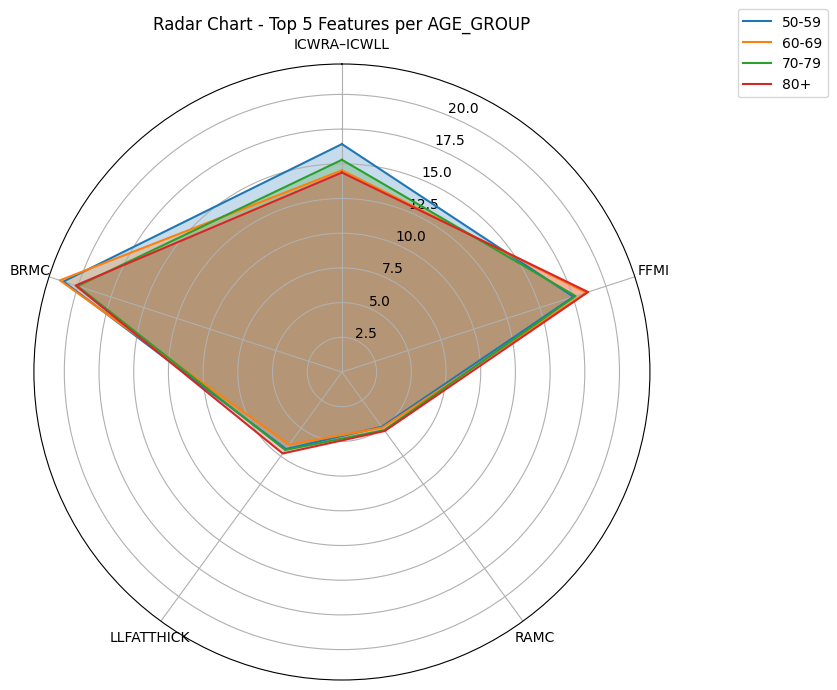

In [24]:
# Step 10.1 - Radar Chart of Top N Features per AGE_GROUP

import matplotlib.pyplot as plt
import numpy as np

# Use top N global features (from Step 6 or Step 9)
top_n = 5
top_features = feature_importances.head(top_n).index.tolist()
print(f"Radar chart for features: {top_features}")

# Compute per-group median values
group_stats = merged_df_clean.groupby('AGE_GROUP')[top_features].median()

# Prepare data for Radar chart
labels = top_features
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for group in group_stats.index:
    values = group_stats.loc[group].values.flatten().tolist()
    values += values[:1]  # close the loop
    ax.plot(angles, values, label=group)
    ax.fill(angles, values, alpha=0.25)

# Format Radar chart
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title(f'Radar Chart - Top {top_n} Features per AGE_GROUP')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()



=== SHAP summary for AGE_GROUP: 50-59 ===


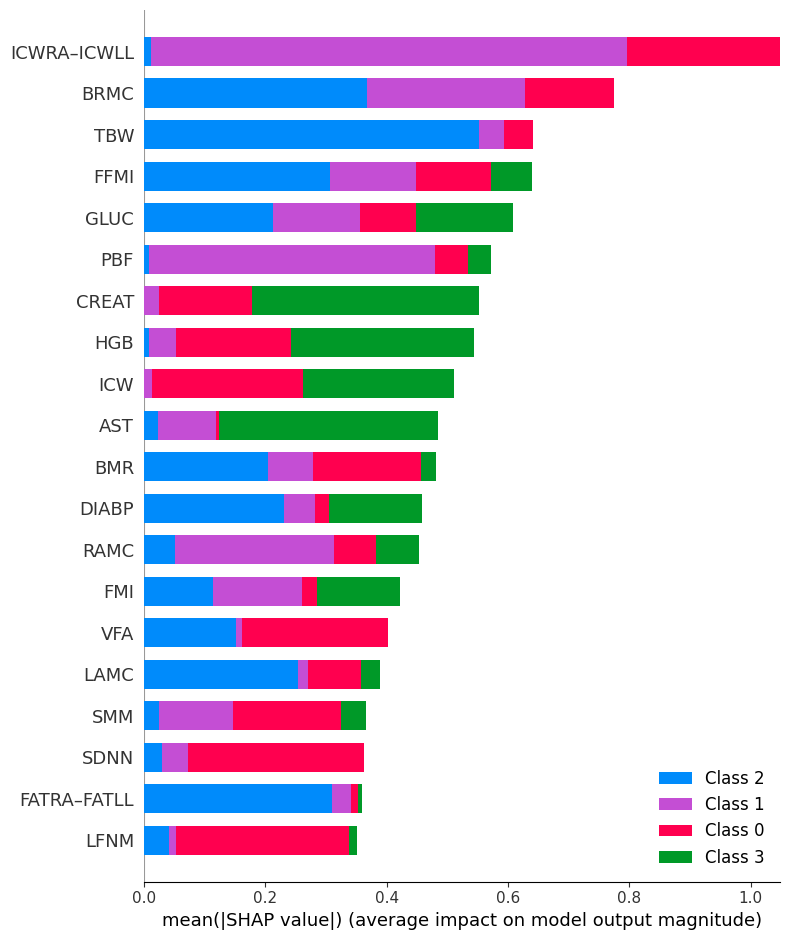


=== SHAP summary for AGE_GROUP: 60-69 ===


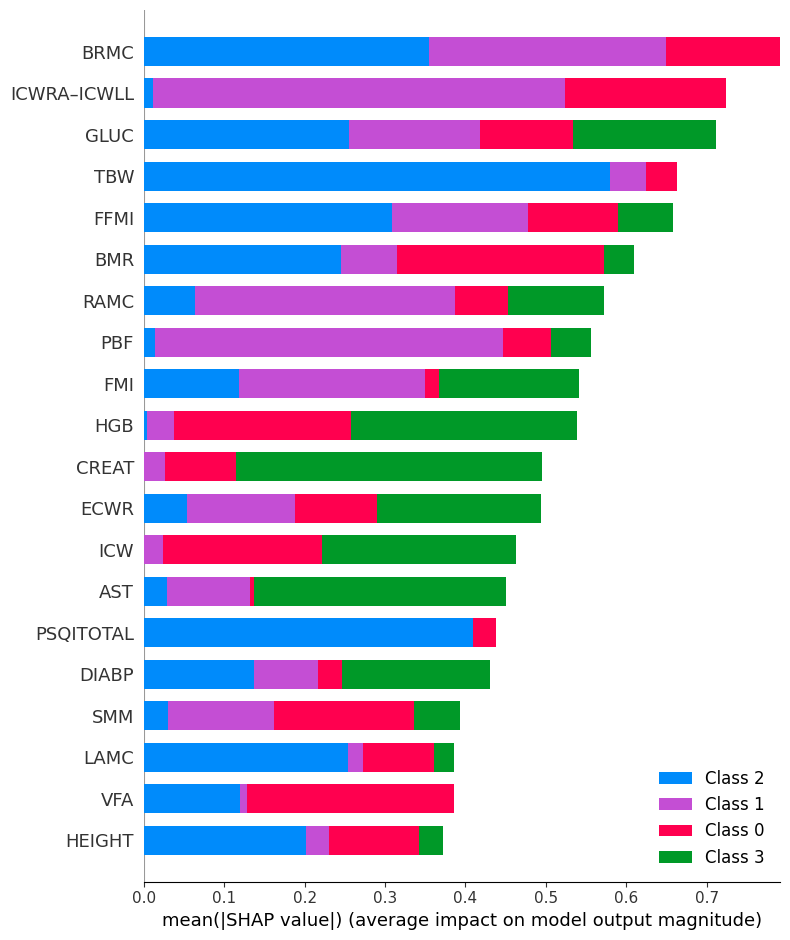


=== SHAP summary for AGE_GROUP: 70-79 ===


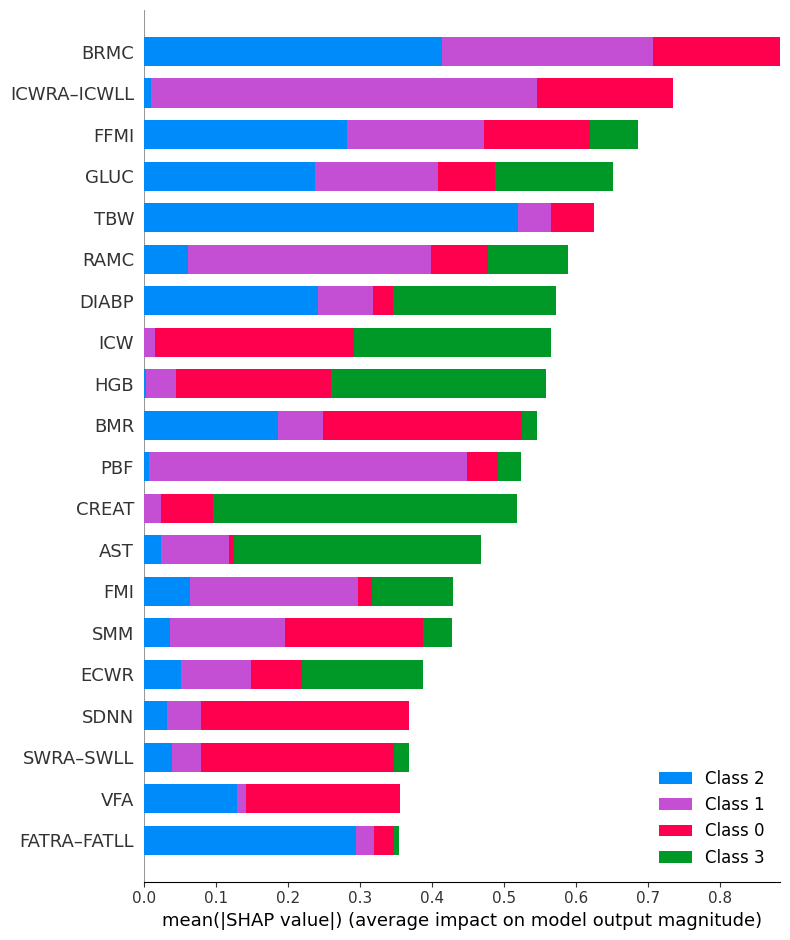


=== SHAP summary for AGE_GROUP: 80+ ===


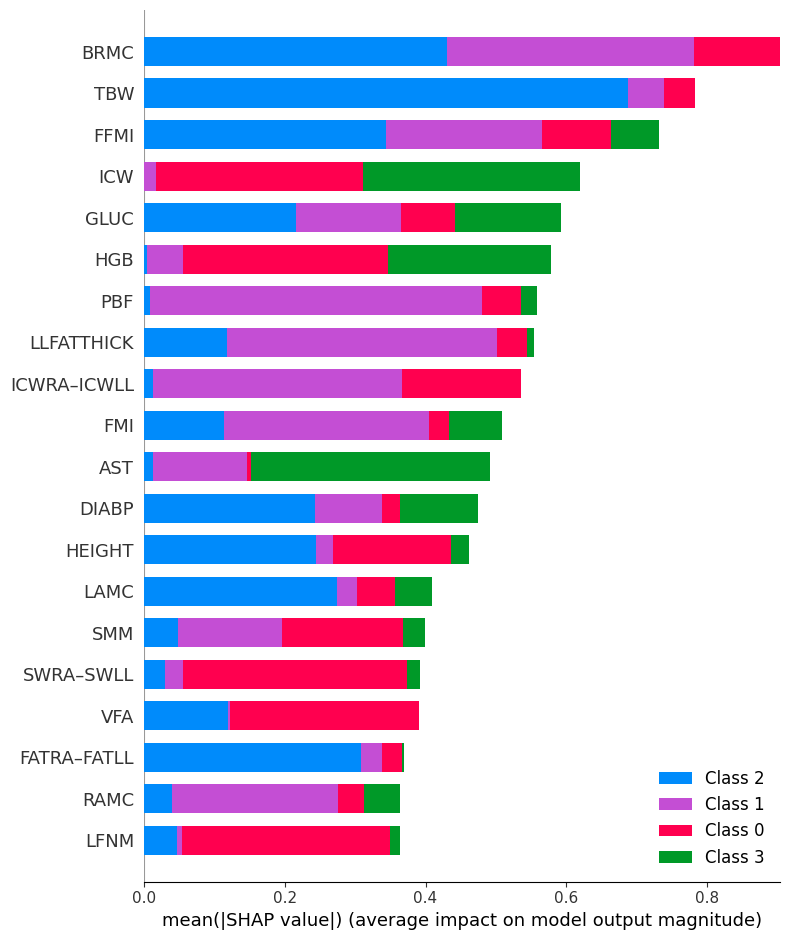

In [25]:
# Step 11.1 - SHAP per AGE_GROUP (local explanations)

for group in le.classes_:
    print(f"\n=== SHAP summary for AGE_GROUP: {group} ===")
    
    # Filter test samples in this group
    group_mask = (y_test == group).values
    X_group_scaled = X_test_scaled[group_mask]
    
    if X_group_scaled.shape[0] == 0:
        print("No samples in this group → skipping.")
        continue
    
    # Compute SHAP for this group
    shap_values_group = explainer_xgb(X_group_scaled)
    
    # Plot
    shap.summary_plot(shap_values_group, X_test.iloc[group_mask], feature_names=X.columns)


In [26]:
from sklearn.model_selection import cross_val_score

# Example with RandomForest
cv_scores = cross_val_score(model_rf, X_train_scaled, y_train, cv=5, scoring='f1_macro')
print(f"Cross-validated F1 Macro (5 folds): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validated F1 Macro (5 folds): 0.1802 ± 0.0369


In [27]:
# Fairness analysis by SEX
for sex_value in merged_df_clean['SEX'].unique():
    print(f"\n=== Results for SEX = {sex_value} ===")
    
    # Select test samples for this SEX
    sex_mask = (merged_df_clean.loc[y_test.index, 'SEX'] == sex_value).values
    X_sex_scaled = X_test_scaled[sex_mask]
    y_sex = y_test[sex_mask]
    
    if X_sex_scaled.shape[0] == 0:
        print("No samples → skipping.")
        continue
    
    # Predict
    y_pred_sex = model_xgb.predict(X_sex_scaled)
    y_pred_labels_sex = le.inverse_transform(y_pred_sex)
    
    # Metrics
    acc = accuracy_score(y_sex, y_pred_labels_sex)
    f1 = f1_score(y_sex, y_pred_labels_sex, average='macro')
    
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Macro: {f1:.4f}")



=== Results for SEX = Male ===
Accuracy: 0.4828
F1 Macro: 0.3753

=== Results for SEX = Female ===
Accuracy: 0.3571
F1 Macro: 0.2381


=== Step 11.1 - SHAP per AGE_GROUP ===

=== SHAP summary for AGE_GROUP: 50-59 ===


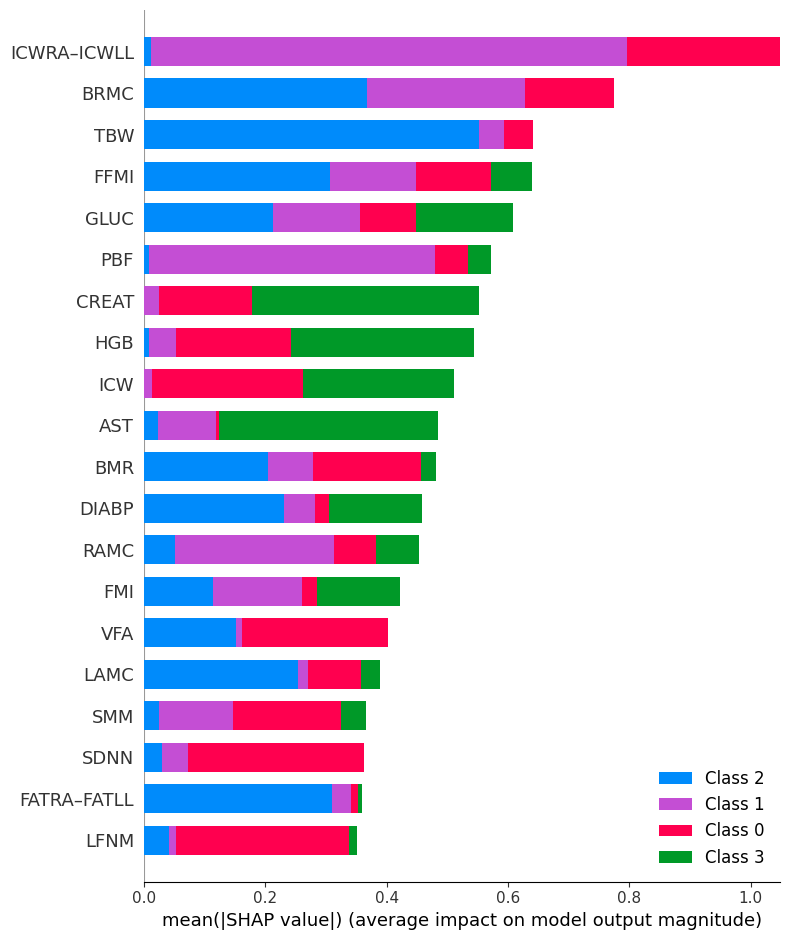


=== SHAP summary for AGE_GROUP: 60-69 ===


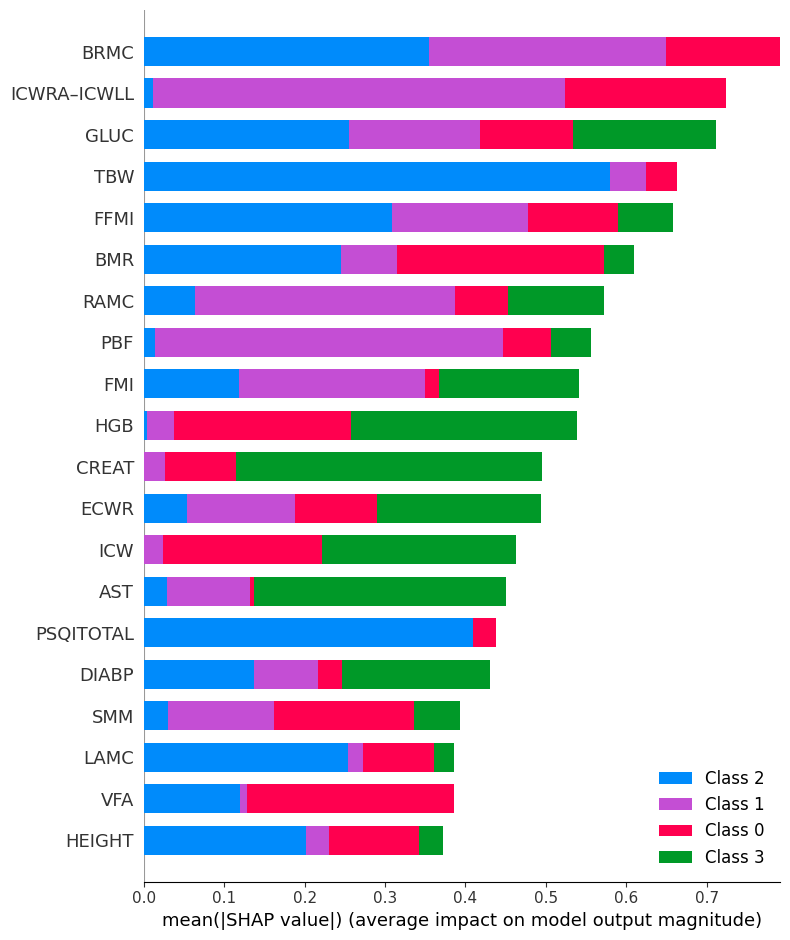


=== SHAP summary for AGE_GROUP: 70-79 ===


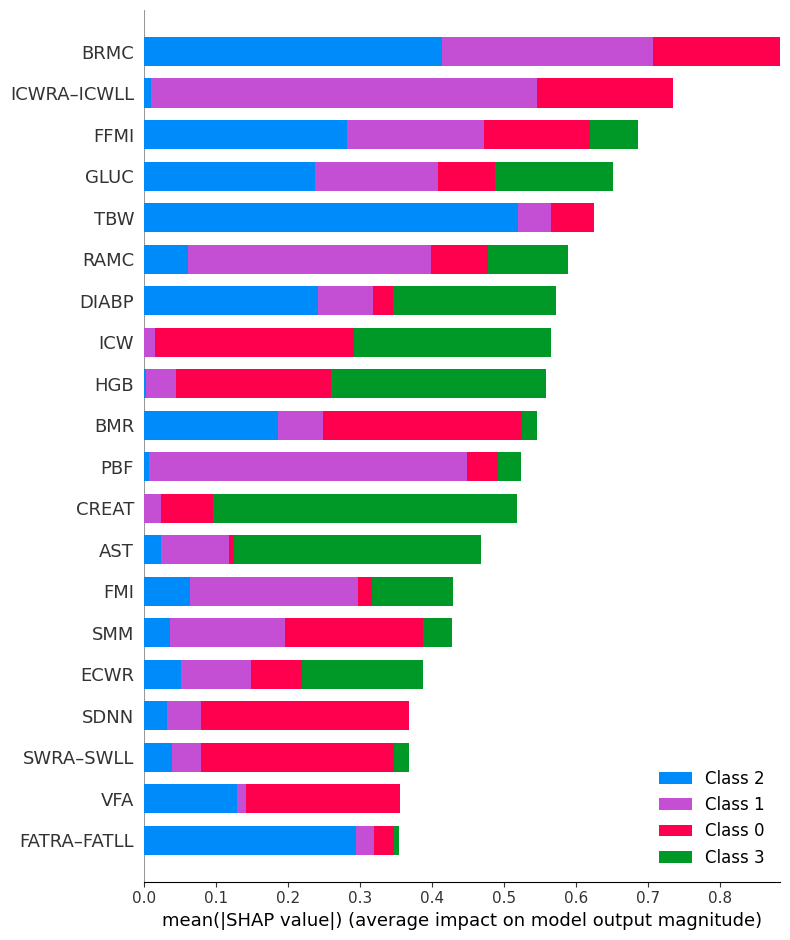


=== SHAP summary for AGE_GROUP: 80+ ===


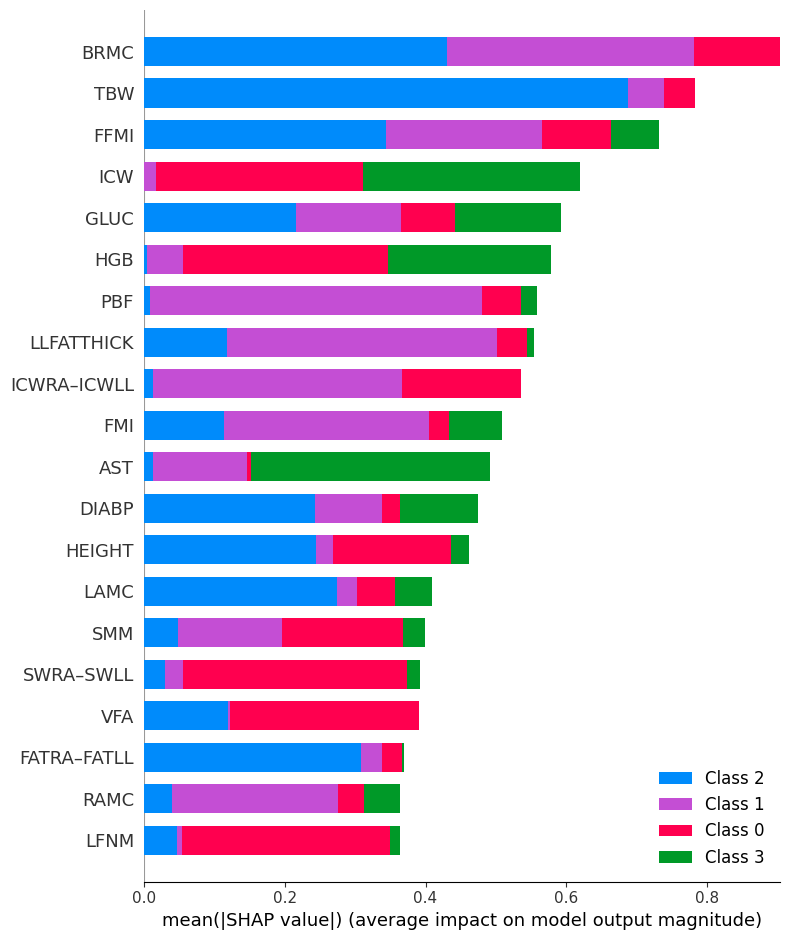


=== Step 11.2 - Cross-validation on RandomForest ===
RandomForest - Cross-validated F1 Macro (5 folds): 0.1802 ± 0.0369


c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\xgboost\training.py:183: UserWarning: [04:29:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\xgboost\training.py:183: UserWarning: [04:29:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\xgboost\training.py:183: UserWarning: [04:29:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\xgboost\training.py:183: UserWarning: [04:29:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encode

XGBoost - Cross-validated F1 Macro (5 folds): 0.1559 ± 0.0487

=== Step 11.3 - Fairness Analysis by SEX ===

=== Results for SEX = Male ===
Accuracy: 0.4828
F1 Macro: 0.3753

=== Results for SEX = Female ===
Accuracy: 0.3571
F1 Macro: 0.2381


In [28]:
# Step 11.1 - SHAP per AGE_GROUP (local explanations)

print("=== Step 11.1 - SHAP per AGE_GROUP ===")

for group in le.classes_:
    print(f"\n=== SHAP summary for AGE_GROUP: {group} ===")
    
    # Filter test samples in this group
    group_mask = (y_test == group).values
    X_group_scaled = X_test_scaled[group_mask]
    
    if X_group_scaled.shape[0] == 0:
        print("No samples in this group → skipping.")
        continue
    
    # Compute SHAP for this group
    shap_values_group = explainer_xgb(X_group_scaled)
    
    # Plot
    shap.summary_plot(shap_values_group, X_test.iloc[group_mask], feature_names=X.columns)

# ------------------------------------------------------------

# Step 11.2 - Cross-validation

print("\n=== Step 11.2 - Cross-validation on RandomForest ===")

from sklearn.model_selection import cross_val_score

# Cross-validation on RandomForest
cv_scores_rf = cross_val_score(model_rf, X_train_scaled, y_train, cv=5, scoring='f1_macro')
print(f"RandomForest - Cross-validated F1 Macro (5 folds): {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")

# Cross-validation on XGBoost (using label encoded y)
cv_scores_xgb = cross_val_score(model_xgb, X_train_scaled, y_train_enc, cv=5, scoring='f1_macro')
print(f"XGBoost - Cross-validated F1 Macro (5 folds): {cv_scores_xgb.mean():.4f} ± {cv_scores_xgb.std():.4f}")

# ------------------------------------------------------------

# Step 11.3 - Fairness analysis by SEX

print("\n=== Step 11.3 - Fairness Analysis by SEX ===")

for sex_value in merged_df_clean['SEX'].unique():
    print(f"\n=== Results for SEX = {sex_value} ===")
    
    # Select test samples for this SEX
    sex_mask = (merged_df_clean.loc[y_test.index, 'SEX'] == sex_value).values
    X_sex_scaled = X_test_scaled[sex_mask]
    y_sex = y_test[sex_mask]
    
    if X_sex_scaled.shape[0] == 0:
        print("No samples → skipping.")
        continue
    
    # Predict with XGBoost
    y_pred_sex = model_xgb.predict(X_sex_scaled)
    y_pred_labels_sex = le.inverse_transform(y_pred_sex)
    
    # Metrics
    acc = accuracy_score(y_sex, y_pred_labels_sex)
    f1 = f1_score(y_sex, y_pred_labels_sex, average='macro')
    
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Macro: {f1:.4f}")


In [30]:
# 0️⃣ Initialize REPORT
REPORT = ""
REPORT += "=== AGE_GROUP Classification Pipeline Report ===\n"
REPORT += "===============================================\n\n"


In [31]:
bio_df = pd.read_excel('Bioimpedance_Synthetic.xlsx')
health_df = pd.read_excel('Health_Exam_Synthetic.xlsx')
hrv_df = pd.read_excel('HRV_Synthetic.xlsx')

merged_df = health_df.merge(bio_df, on='USUBJID').merge(hrv_df, on='USUBJID')

REPORT += "Step 1 - Load & Merge Datasets:\n"
REPORT += f"Merged dataframe shape: {merged_df.shape}\n\n"


In [32]:
merged_df['BIRTHDTC'] = pd.to_datetime(merged_df['BIRTHDTC'], errors='coerce')
ref_date = pd.to_datetime('2024-01-01')
merged_df['AGE'] = (ref_date - merged_df['BIRTHDTC']).dt.days // 365

merged_df['AGE_GROUP'] = pd.cut(
    merged_df['AGE'],
    bins=[50, 60, 70, 80, 120],
    labels=['50-59', '60-69', '70-79', '80+']
)

merged_df_clean = merged_df.dropna(subset=['AGE_GROUP'])

REPORT += "Step 2 - AGE_GROUP Binning:\n"
REPORT += str(merged_df_clean['AGE_GROUP'].value_counts()) + "\n\n"


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

drop_cols = ['USUBJID', 'BIRTHDTC', 'AGE', 'AGE_GROUP']
X = merged_df_clean.drop(columns=drop_cols).select_dtypes(include='number')
y = merged_df_clean['AGE_GROUP']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

REPORT += f"Step 3 - Feature Preparation:\nSelected {X.shape[1]} numerical features.\n\n"



====== Logistic Regression ======


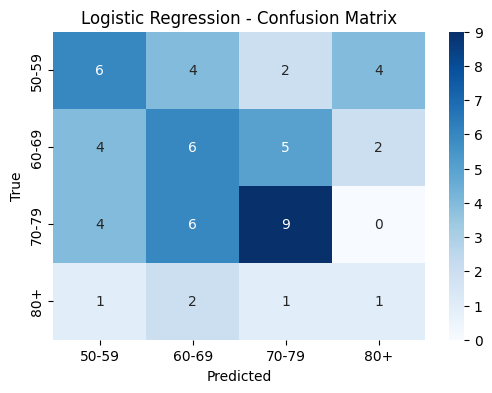


====== Random Forest ======


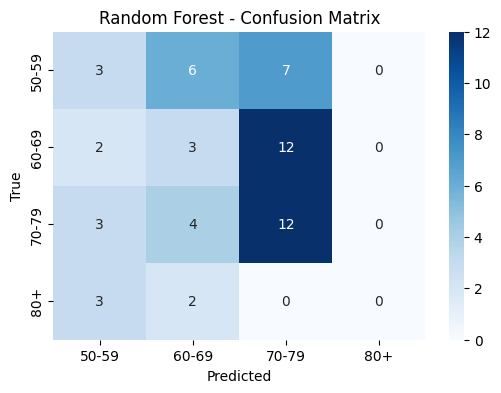


====== XGBoost ======


c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\xgboost\training.py:183: UserWarning: [05:00:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


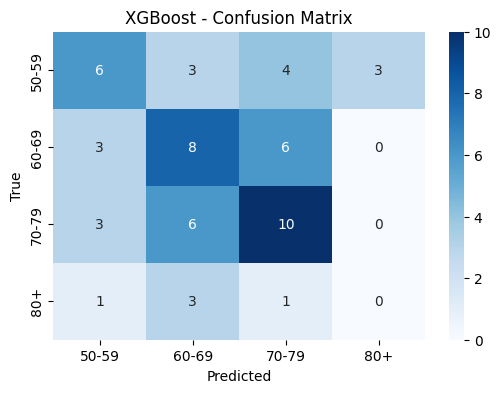

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    REPORT += f"Step 4 - {name} Training:\n"
    print(f"\n====== {name} ======")
    
    if name == 'XGBoost':
        model.fit(X_train_scaled, y_train_enc)
        y_pred = model.predict(X_test_scaled)
        y_pred_labels = le.inverse_transform(y_pred)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred_labels = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred_labels)
    f1 = f1_score(y_test, y_pred_labels, average='macro')
    
    REPORT += f"Accuracy: {acc:.4f}\nF1 Score (macro): {f1:.4f}\n\n"
    
    cm = confusion_matrix(y_test, y_pred_labels, labels=le.classes_)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


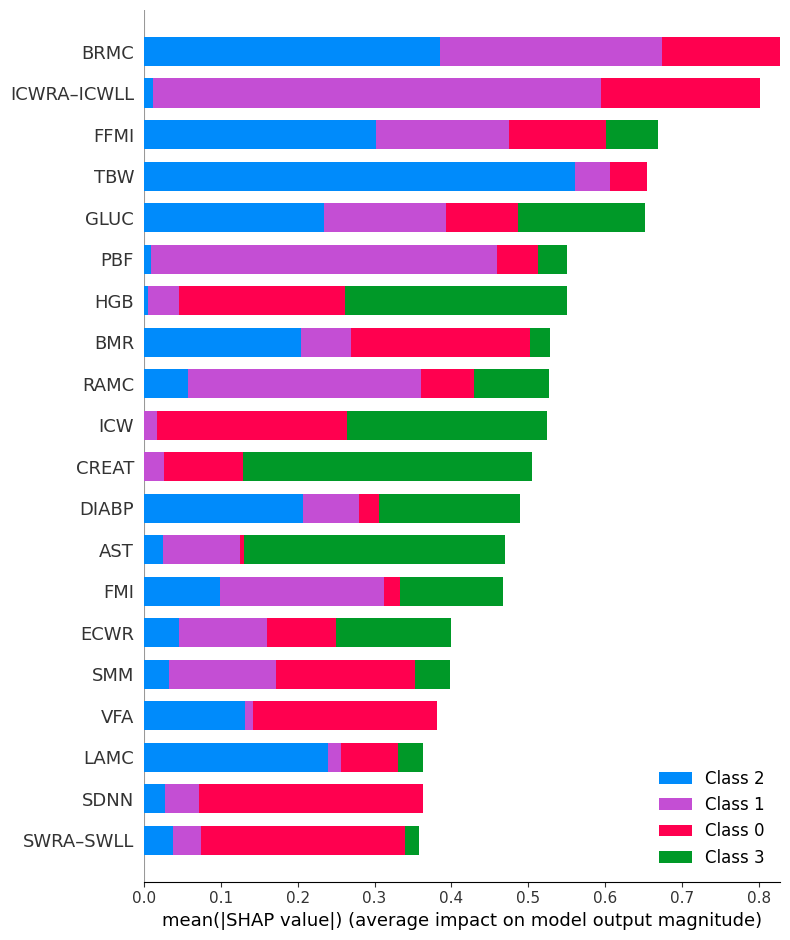

In [36]:
import shap

model_xgb = models['XGBoost']
explainer_xgb = shap.Explainer(model_xgb, X_train_scaled)
shap_values_xgb = explainer_xgb(X_test_scaled)

shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns)

# Log to REPORT
# Correct way to compute mean absolute SHAP per feature across all classes:
shap_importances = np.abs(shap_values_xgb.values).mean(axis=(0,2))  # Mean over samples and classes

# Now get top features
top_shap_idx = np.argsort(shap_importances)[::-1][:5]
top_shap_features = X.columns.to_numpy()[top_shap_idx].tolist()


REPORT += "Step 5 - SHAP Explainability:\n"
REPORT += f"Top 5 SHAP Features: {top_shap_features}\n\n"


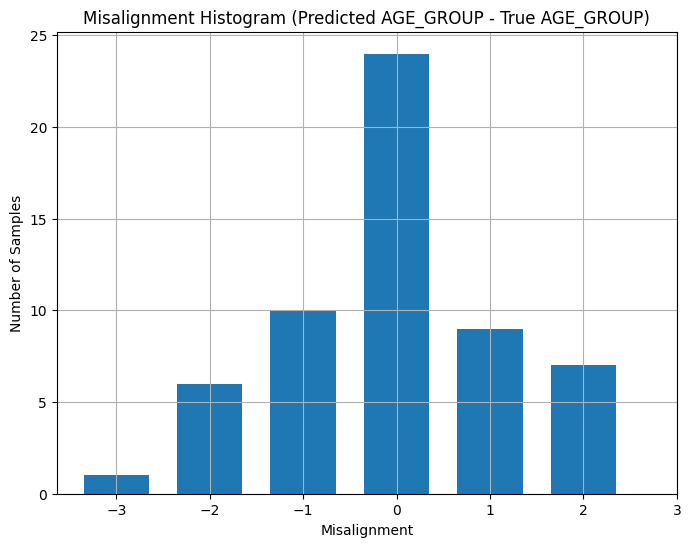

In [37]:
age_group_order = {'50-59': 0, '60-69': 1, '70-79': 2, '80+': 3}

y_test_ord = y_test.map(age_group_order).astype(int).values
y_pred_ord = pd.Series(le.inverse_transform(model_xgb.predict(X_test_scaled))).map(age_group_order).astype(int).values

misalignment = y_pred_ord - y_test_ord

n_total = len(misalignment)
n_accelerated = (misalignment > 0).sum()
percent_accelerated = 100 * n_accelerated / n_total

plt.figure(figsize=(8,6))
plt.hist(misalignment, bins=np.arange(-3,4), align='left', rwidth=0.7)
plt.xticks(ticks=[-3, -2, -1, 0, 1, 2, 3])
plt.title("Misalignment Histogram (Predicted AGE_GROUP - True AGE_GROUP)")
plt.xlabel("Misalignment")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

# Log to REPORT
REPORT += "Step 8 - Accelerated Aging Detection:\n"
REPORT += f"Total samples: {n_total}\n"
REPORT += f"Samples flagged as accelerated aging: {n_accelerated}\n"
REPORT += f"Percent accelerated aging: {percent_accelerated:.2f}%\n\n"

if percent_accelerated > 30:
    REPORT += "Warning: High proportion of accelerated aging detected → review model and feature contributions.\n\n"
elif percent_accelerated < 10:
    REPORT += "Low proportion of accelerated aging → model conservative in older predictions.\n\n"
else:
    REPORT += "Moderate level of accelerated aging detected.\n\n"


In [38]:
# Final REPORT output
with open("AGE_GROUP_analysis_report.txt", "w") as f:
    f.write(REPORT)

# Also print to screen
print(REPORT)


=== AGE_GROUP Classification Pipeline Report ===

Step 1 - Load & Merge Datasets:
Merged dataframe shape: (200, 80)

Step 2 - AGE_GROUP Binning:
AGE_GROUP
70-79    62
60-69    56
50-59    51
80+      18
Name: count, dtype: int64

Step 3 - Feature Preparation:
Selected 65 numerical features.

Step 4 - Logistic Regression Training:
Accuracy: 0.3860
F1 Score (macro): 0.3492

Step 4 - Random Forest Training:
Accuracy: 0.3158
F1 Score (macro): 0.2224

Step 4 - XGBoost Training:
Accuracy: 0.4211
F1 Score (macro): 0.3366

Step 5 - SHAP Explainability:
Top 5 SHAP Features: ['BRMC', 'ICWRA–ICWLL', 'FFMI', 'TBW', 'GLUC']

Step 8 - Accelerated Aging Detection:
Total samples: 57
Samples flagged as accelerated aging: 16
Percent accelerated aging: 28.07%

Moderate level of accelerated aging detected.





====== Logistic Regression ======


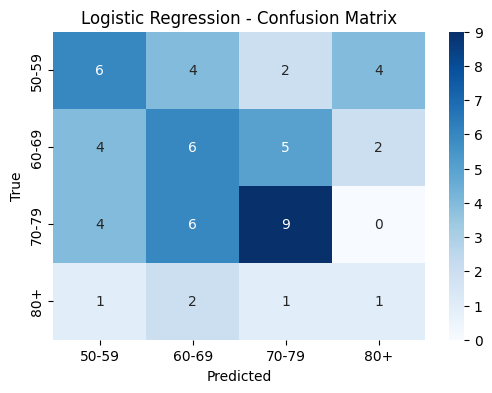


====== Random Forest ======


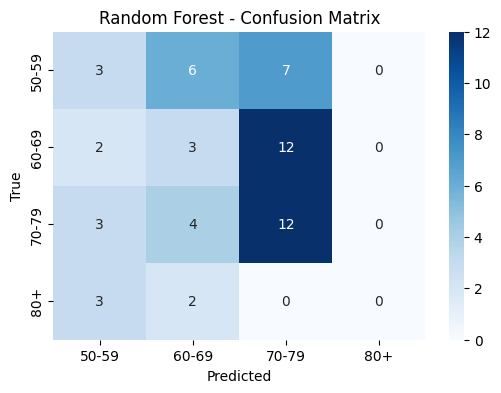


====== XGBoost ======


c:\Users\RAZER\anaconda3\envs\sha\lib\site-packages\xgboost\training.py:183: UserWarning: [05:06:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


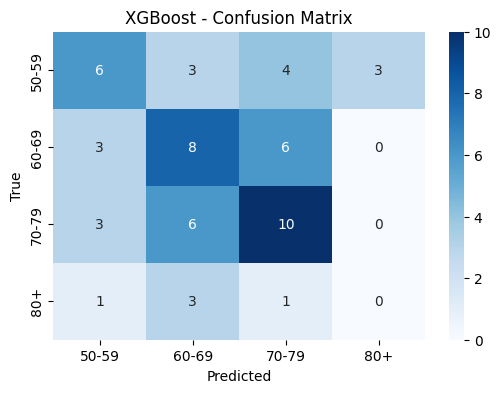

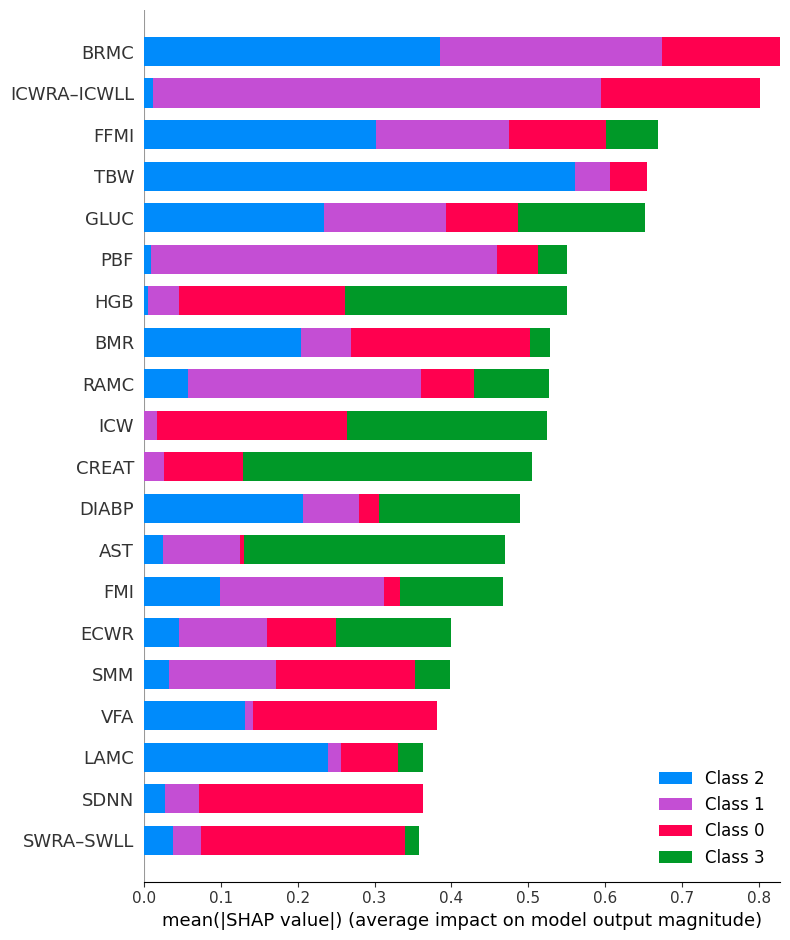

C:\Users\RAZER\AppData\Local\Temp\ipykernel_50332\1111662450.py:123: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = merged_df_clean.groupby('AGE_GROUP')[feature].median()


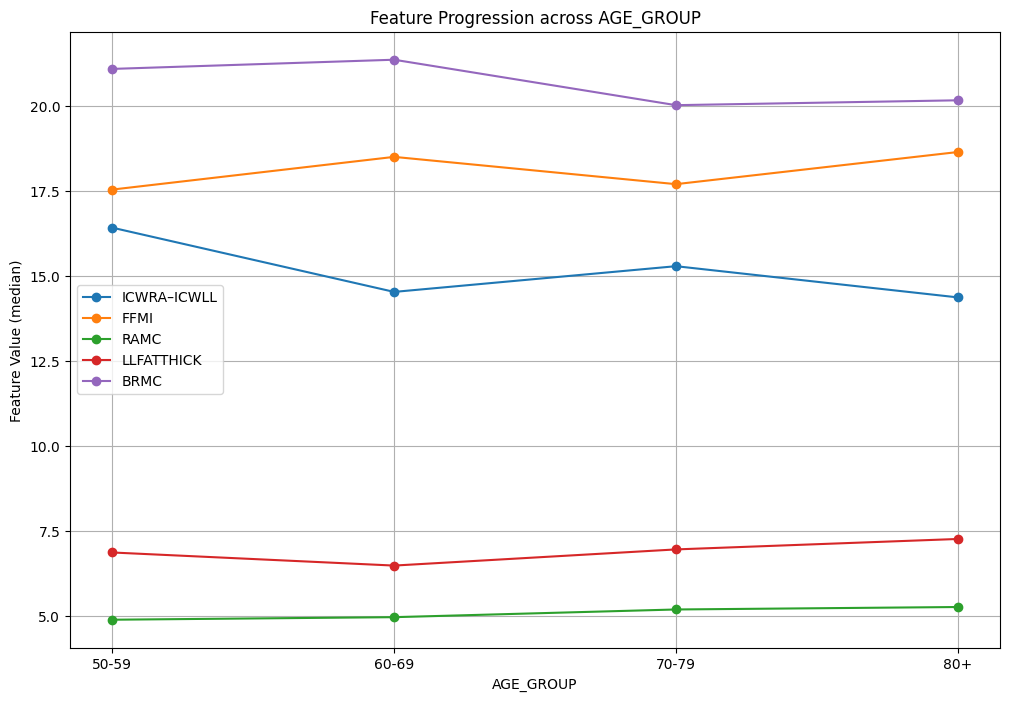

C:\Users\RAZER\AppData\Local\Temp\ipykernel_50332\1111662450.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values = merged_df_clean.groupby('AGE_GROUP')[feature].median()


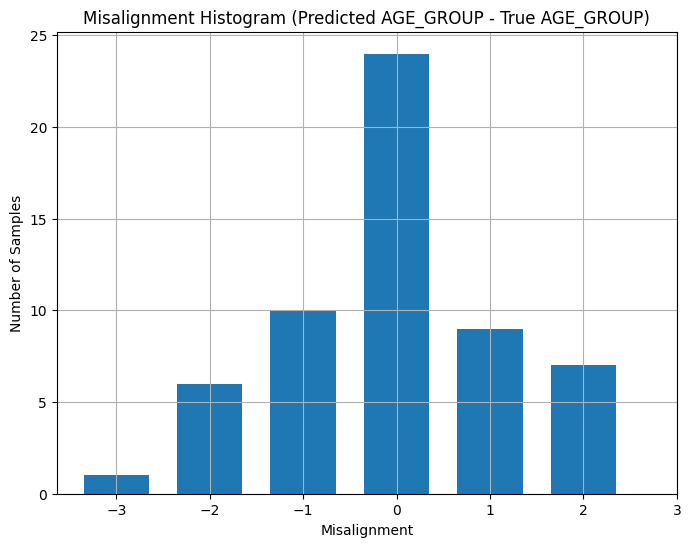

=== AGE_GROUP Classification Pipeline Report ===

Step 1 - Load & Merge Datasets:
Merged dataframe shape: (200, 80)

Step 2 - AGE_GROUP Binning:
AGE_GROUP
70-79    62
60-69    56
50-59    51
80+      18
Name: count, dtype: int64

Step 3 - Feature Preparation:
Selected 65 numerical features.

Step 4 - Logistic Regression Training:
Accuracy: 0.3860
F1 Score (macro): 0.3492

Step 4 - Random Forest Training:
Accuracy: 0.3158
F1 Score (macro): 0.2224

Step 4 - XGBoost Training:
Accuracy: 0.4211
F1 Score (macro): 0.3366

Step 5 - SHAP Explainability:
Top 5 SHAP Features: ['BRMC', 'ICWRA–ICWLL', 'FFMI', 'TBW', 'GLUC']

=== Step 6 - Detailed Feature Progression & Correlation Analysis ===
Top 5 Features: ['ICWRA–ICWLL', 'FFMI', 'RAMC', 'LLFATTHICK', 'BRMC']


Feature: ICWRA–ICWLL
- Correlation with AGE: r = -0.15 (p = 0.0355)
- Kruskal-Wallis p-value across AGE_GROUPs: p = 0.0061
- Median value varies across AGE_GROUPs.
- Interpretation: Weak or complex correlation → may reflect non-linear agin

In [40]:
# === Full AGE_GROUP Classification Pipeline - Single Cell Version ===

# Initialize REPORT
REPORT = ""
REPORT += "=== AGE_GROUP Classification Pipeline Report ===\n"
REPORT += "===============================================\n\n"

# 1️⃣ Load & Merge Datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import shap
from scipy.stats import pearsonr, kruskal

bio_df = pd.read_excel('Bioimpedance_Synthetic.xlsx')
health_df = pd.read_excel('Health_Exam_Synthetic.xlsx')
hrv_df = pd.read_excel('HRV_Synthetic.xlsx')

merged_df = health_df.merge(bio_df, on='USUBJID').merge(hrv_df, on='USUBJID')

REPORT += "Step 1 - Load & Merge Datasets:\n"
REPORT += f"Merged dataframe shape: {merged_df.shape}\n\n"

# 2️⃣ AGE Computation + AGE_GROUP Binning
merged_df['BIRTHDTC'] = pd.to_datetime(merged_df['BIRTHDTC'], errors='coerce')
ref_date = pd.to_datetime('2024-01-01')
merged_df['AGE'] = (ref_date - merged_df['BIRTHDTC']).dt.days // 365

merged_df['AGE_GROUP'] = pd.cut(
    merged_df['AGE'],
    bins=[50, 60, 70, 80, 120],
    labels=['50-59', '60-69', '70-79', '80+']
)

merged_df_clean = merged_df.dropna(subset=['AGE_GROUP'])

REPORT += "Step 2 - AGE_GROUP Binning:\n"
REPORT += str(merged_df_clean['AGE_GROUP'].value_counts()) + "\n\n"

# 3️⃣ Feature Preparation + Scaling
drop_cols = ['USUBJID', 'BIRTHDTC', 'AGE', 'AGE_GROUP']
X = merged_df_clean.drop(columns=drop_cols).select_dtypes(include='number')
y = merged_df_clean['AGE_GROUP']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

REPORT += f"Step 3 - Feature Preparation:\nSelected {X.shape[1]} numerical features.\n\n"

# 4️⃣ Model Training + Logging
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    REPORT += f"Step 4 - {name} Training:\n"
    print(f"\n====== {name} ======")
    
    if name == 'XGBoost':
        model.fit(X_train_scaled, y_train_enc)
        y_pred = model.predict(X_test_scaled)
        y_pred_labels = le.inverse_transform(y_pred)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred_labels = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred_labels)
    f1 = f1_score(y_test, y_pred_labels, average='macro')
    
    REPORT += f"Accuracy: {acc:.4f}\nF1 Score (macro): {f1:.4f}\n\n"
    
    cm = confusion_matrix(y_test, y_pred_labels, labels=le.classes_)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 5️⃣ SHAP Explainability + Logging
model_xgb = models['XGBoost']
explainer_xgb = shap.Explainer(model_xgb, X_train_scaled)
shap_values_xgb = explainer_xgb(X_test_scaled)

shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns)

# Aggregate SHAP values
shap_importances = np.abs(shap_values_xgb.values).mean(axis=(0,2))
top_shap_idx = np.argsort(shap_importances)[::-1][:5]
top_shap_features = X.columns.to_numpy()[top_shap_idx].tolist()

REPORT += "Step 5 - SHAP Explainability:\n"
REPORT += f"Top 5 SHAP Features: {top_shap_features}\n\n"

# 6️⃣ Detailed Feature Progression & Correlation Analysis
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)

feature_importances = pd.Series(model_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = feature_importances.head(5).index.tolist()

plt.figure(figsize=(12, 8))
for feature in top_features:
    group_stats = merged_df_clean.groupby('AGE_GROUP')[feature].median()
    plt.plot(group_stats.index, group_stats.values, marker='o', label=feature)

plt.title("Feature Progression across AGE_GROUP")
plt.xlabel("AGE_GROUP")
plt.ylabel("Feature Value (median)")
plt.legend()
plt.grid(True)
plt.show()

# Log detailed explanations
REPORT += "=== Step 6 - Detailed Feature Progression & Correlation Analysis ===\n"
REPORT += f"Top {len(top_features)} Features: {top_features}\n\n"

for feature in top_features:
    try:
        corr_r, corr_p = pearsonr(merged_df_clean['AGE'], merged_df_clean[feature])
    except:
        corr_r, corr_p = (np.nan, np.nan)
    
    groups = [merged_df_clean[merged_df_clean['AGE_GROUP']==grp][feature] for grp in merged_df_clean['AGE_GROUP'].unique()]
    try:
        stat, p_value = kruskal(*groups)
    except:
        stat, p_value = (np.nan, np.nan)
    
    values = merged_df_clean.groupby('AGE_GROUP')[feature].median()
    trend = "increases" if values.is_monotonic_increasing else ("decreases" if values.is_monotonic_decreasing else "varies")
    
    REPORT += f"\nFeature: {feature}\n"
    REPORT += f"- Correlation with AGE: r = {corr_r:.2f} (p = {corr_p:.4f})\n"
    REPORT += f"- Kruskal-Wallis p-value across AGE_GROUPs: p = {p_value:.4f}\n"
    REPORT += f"- Median value {trend} across AGE_GROUPs.\n"
    
    if not np.isnan(corr_p) and corr_p < 0.05:
        if corr_r > 0.3:
            REPORT += "- Interpretation: Strong positive correlation with AGE → likely increases with aging.\n"
        elif corr_r < -0.3:
            REPORT += "- Interpretation: Strong negative correlation with AGE → likely decreases with aging.\n"
        else:
            REPORT += "- Interpretation: Weak or complex correlation → may reflect non-linear aging effects.\n"
    else:
        REPORT += "- Interpretation: No significant correlation with AGE.\n"

REPORT += "\n"

# 8️⃣ Accelerated Aging Detection + Logging
age_group_order = {'50-59': 0, '60-69': 1, '70-79': 2, '80+': 3}

y_test_ord = y_test.map(age_group_order).astype(int).values
y_pred_ord = pd.Series(le.inverse_transform(model_xgb.predict(X_test_scaled))).map(age_group_order).astype(int).values

misalignment = y_pred_ord - y_test_ord

n_total = len(misalignment)
n_accelerated = (misalignment > 0).sum()
percent_accelerated = 100 * n_accelerated / n_total

plt.figure(figsize=(8,6))
plt.hist(misalignment, bins=np.arange(-3,4), align='left', rwidth=0.7)
plt.xticks(ticks=[-3, -2, -1, 0, 1, 2, 3])
plt.title("Misalignment Histogram (Predicted AGE_GROUP - True AGE_GROUP)")
plt.xlabel("Misalignment")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

REPORT += "Step 8 - Accelerated Aging Detection:\n"
REPORT += f"Total samples: {n_total}\n"
REPORT += f"Samples flagged as accelerated aging: {n_accelerated}\n"
REPORT += f"Percent accelerated aging: {percent_accelerated:.2f}%\n\n"

if percent_accelerated > 30:
    REPORT += "Warning: High proportion of accelerated aging detected → review model and feature contributions.\n\n"
elif percent_accelerated < 10:
    REPORT += "Low proportion of accelerated aging → model conservative in older predictions.\n\n"
else:
    REPORT += "Moderate level of accelerated aging detected.\n\n"

# Final step - SAVE REPORT to file
with open("AGE_GROUP_analysis_report.txt", "w") as f:
    f.write(REPORT)

# Also print full REPORT
print(REPORT)
